<a href="https://colab.research.google.com/github/mariuszkx5/ML-Projects/blob/master/Project_Cancer_Diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch

In [0]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
from google.colab import files
uploaded = files.upload()

Saving Data.txt to Data.txt


In [0]:
df = pd.read_table('Data.txt', sep=',', header=None)

In [139]:
type(df)

pandas.core.frame.DataFrame

Missing data

In [0]:
df.fillna(value=df.mean(), inplace = True)

# Data Exploration

In [0]:
labels = ['malignant', 'benign']

In [0]:
values = [df[1].value_counts()['M'], df[1].value_counts()['B']]

In [143]:
df[1].value_counts()

B    357
M    212
Name: 1, dtype: int64

Text(0.5, 0, 'Type of the cancer')

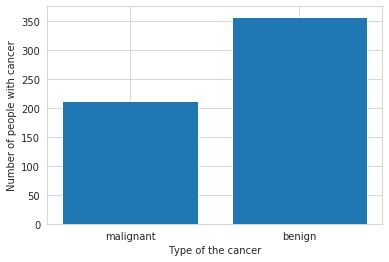

In [144]:
plt.bar(labels, values)
plt.ylabel('Number of people with cancer')
plt.xlabel('Type of the cancer')

I see that I have unbalanced data

I decided to use the up-sample the minority class

In [0]:
from sklearn.utils import resample

In [0]:
# Separate majority and minority classes
df_majority = df[df[1]=='B']
df_minority = df[df[1]=='M']
 

In [0]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

In [0]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [149]:
df_upsampled[1].value_counts()

B    357
M    357
Name: 1, dtype: int64

In [0]:
y = df.iloc[:,1].values
X = np.delete(df.values, [0, 1], 1)

Features density

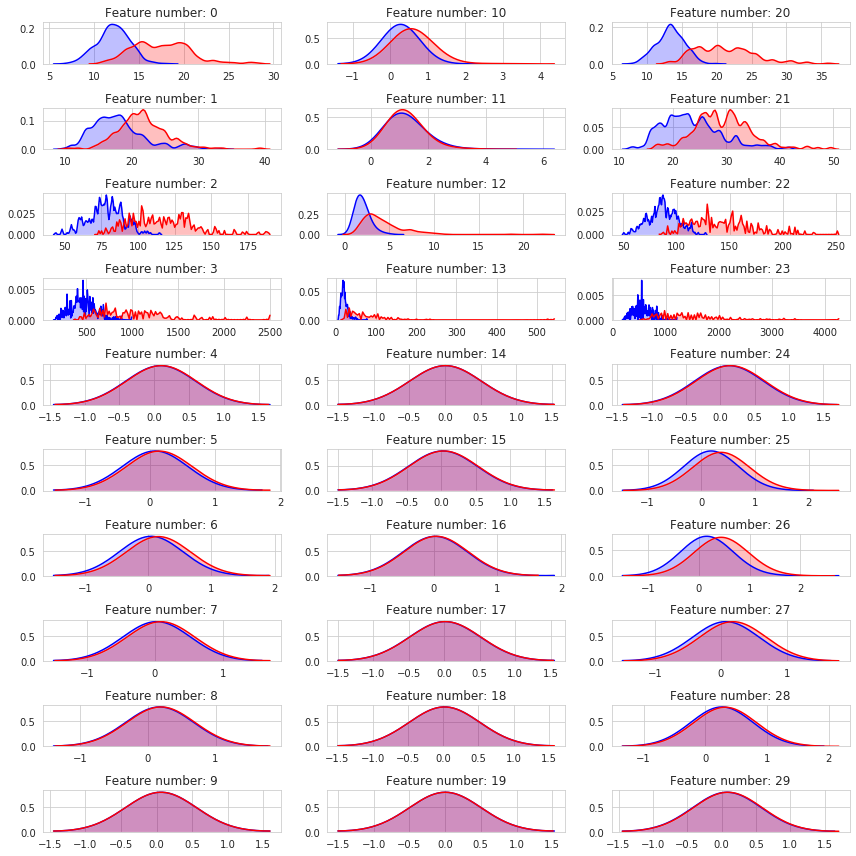

In [151]:
import seaborn as sns

f, axes = plt.subplots(10, 3, figsize=(12,12))
sns.set_style('whitegrid')

feature_number = 0 
for j in range(3):
  for i in range(10):
    sns.kdeplot(X[:,feature_number][y =='B'], bw=0.5, shade=True, color = 'blue', ax=axes[i,j])
    sns.kdeplot(X[:,feature_number][y =='M'], bw=0.5, shade=True, color = 'red', ax=axes[i,j])
    axes[i,j].set_title('Feature number: ' + str(feature_number))
    feature_number += 1

f.tight_layout()

Splitting the data into training data and test data

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Normalization

In [0]:
from sklearn.preprocessing import Normalizer 
norm = Normalizer()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

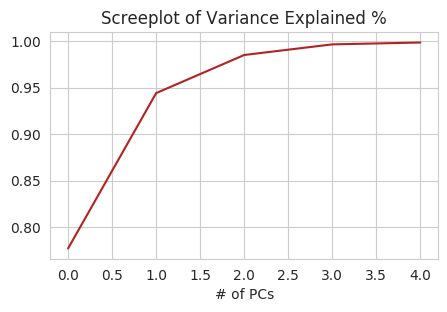

array([0.776889, 0.94433 , 0.985414, 0.996864, 0.998865])

In [156]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(6)
fig, axes = plt.subplots(1,1,figsize=(5,3), dpi=100)
plt.plot(variance_exp_cumsum, color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=12)
plt.xlabel('# of PCs', fontsize=10)
plt.show()
variance_exp_cumsum

Plotting a cancer diagnosis as a function of the first two main elements

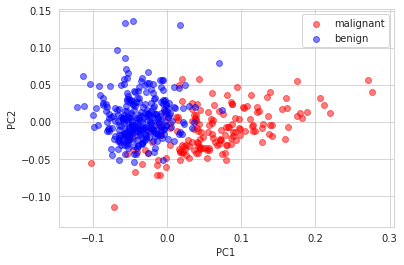

In [157]:
fig, ax = plt.subplots()

ax.scatter(X_train_pca[:,0][y_train =='M'], X_train_pca[:,1][y_train =='M'], c='red', alpha=0.5, label = 'malignant')
ax.scatter(X_train_pca[:,0][y_train =='B'], X_train_pca[:,1][y_train =='B'], c='blue', alpha=0.5 , label = 'benign')

ax.legend()
ax.grid(True)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

T-SNE

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)

In [159]:
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 455 samples in 0.002s...
[t-SNE] Computed neighbors for 455 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 455 / 455
[t-SNE] Mean sigma: 0.016128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.860401
[t-SNE] KL divergence after 1000 iterations: 0.422484


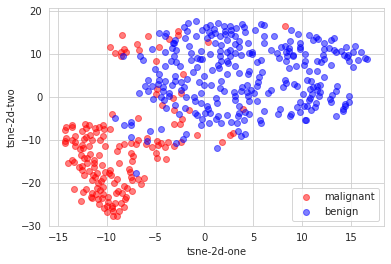

In [160]:
fig, ax = plt.subplots()

ax.scatter(tsne_results[:,0][y_train =='M'], tsne_results[:,1][y_train =='M'], c='red', alpha=0.5, label = 'malignant')
ax.scatter(tsne_results[:,0][y_train =='B'], tsne_results[:,1][y_train =='B'], c='blue', alpha=0.5 , label = 'benign')

ax.legend()
ax.grid(True)

plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.show()

# Classification

## Choosing the best model using K-fold cross-validation

Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']

lr_clf = LogisticRegression(max_iter=1000)

scores = cross_validate(lr_clf, X_train, y_train, scoring=scoring, cv=10)

lr_scores = pd.DataFrame.from_dict(scores).mean()

In [162]:
lr_scores

fit_time                0.011388
score_time              0.006340
test_accuracy           0.756280
test_precision_macro    0.862057
test_recall_macro       0.664338
test_f1_weighted        0.712651
test_roc_auc            0.956554
dtype: float64

Decision tree

In [163]:
from sklearn import tree

dt_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=50)

scores = cross_validate(dt_clf, X_train, y_train, scoring=scoring, cv=10)

dt_clf_scores = pd.DataFrame.from_dict(scores).mean()
dt_clf_scores

fit_time                0.010512
score_time              0.005161
test_accuracy           0.938309
test_precision_macro    0.937439
test_recall_macro       0.930965
test_f1_weighted        0.938175
test_roc_auc            0.930965
dtype: float64

Support-vector machine

In [0]:
from sklearn.svm import SVC

In [165]:
svc = SVC(kernel='rbf')

scores = cross_validate(svc, X_train, y_train, scoring=scoring, cv=10)

svc_scores = pd.DataFrame.from_dict(scores).mean()
svc_scores

fit_time                0.009399
score_time              0.006549
test_accuracy           0.868261
test_precision_macro    0.907494
test_recall_macro       0.821184
test_f1_weighted        0.859720
test_roc_auc            0.960700
dtype: float64

Linear Discriminant Analysis

In [166]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

scores = cross_validate(lda, X_train, y_train, scoring=scoring, cv=10)

lda_scores = pd.DataFrame.from_dict(scores).mean()
lda_scores

fit_time                0.004092
score_time              0.005026
test_accuracy           0.958261
test_precision_macro    0.968094
test_recall_macro       0.943864
test_f1_weighted        0.957400
test_roc_auc            0.988920
dtype: float64


Quadratic Discriminant Analysis

In [0]:
qda = QuadraticDiscriminantAnalysis()

scores = cross_validate(qda, X_train, y_train, scoring=scoring, cv=10)

qda_scores = pd.DataFrame.from_dict(scores).mean()

In [168]:
qda_scores

fit_time                0.002642
score_time              0.005251
test_accuracy           0.914348
test_precision_macro    0.904879
test_recall_macro       0.916202
test_f1_weighted        0.914847
test_roc_auc            0.966265
dtype: float64


Random Forest Classifier

In [169]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)

scores = cross_validate(rfc, X_train, y_train, scoring=scoring, cv=10)

rfc_scores = pd.DataFrame.from_dict(scores).mean()
rfc_scores

fit_time                1.950520
score_time              0.183111
test_accuracy           0.964831
test_precision_macro    0.967210
test_recall_macro       0.956706
test_f1_weighted        0.964608
test_roc_auc            0.989858
dtype: float64

Final models comparison

In [170]:
global_scores = pd.concat([dt_clf_scores, lr_scores, svc_scores, lda_scores, qda_scores, rfc_scores], axis=1) 
global_scores.columns = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest']
global_scores

,Logistic Regression,Decision Tree,Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest
fit_time,0.010512,0.011388,0.009399,0.004092,0.002642,1.950520
score_time,0.005161,0.006340,0.006549,0.005026,0.005251,0.183111
test_accuracy,0.938309,0.756280,0.868261,0.958261,0.914348,0.964831
test_precision_macro,0.937439,0.862057,0.907494,0.968094,0.904879,0.967210
test_recall_macro,0.930965,0.664338,0.821184,0.943864,0.916202,0.956706
test_f1_weighted,0.938175,0.712651,0.859720,0.957400,0.914847,0.964608
test_roc_auc,0.930965,0.956554,0.960700,0.988920,0.966265,0.989858




> The best results were obtained by a random forest classifier, despite the fact that compared to other models, it was trained for a relatively long time, but time is within the acceptable range.



Checking the repeatability of the results of the best model of each validation

In [171]:
pd.DataFrame.from_dict(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_weighted,test_roc_auc
0,1.964191,0.202653,0.978261,0.983333,0.970588,0.978116,1.000000
1,2.003374,0.179541,0.978261,0.983333,0.970588,0.978116,0.995943
2,2.028512,0.154188,0.956522,0.953347,0.953347,0.956522,0.977688
3,1.908522,0.336907,0.978261,0.983333,0.970588,0.978116,1.000000
4,1.908166,0.154698,0.934783,0.935417,0.923935,0.934347,0.959432
5,1.971436,0.161075,0.977778,0.983333,0.968750,0.977608,0.995690
6,1.936502,0.165405,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.953759,0.159429,0.888889,0.883333,0.871767,0.888038,0.980603
8,1.916400,0.158240,0.977778,0.983333,0.968750,0.977608,1.000000
9,1.914337,0.158971,0.977778,0.983333,0.968750,0.977608,0.989224


## Training the best model (Random Forest Classifier) and testing it on the unseen data

In [0]:
rfc = rfc.fit(X_train, y_train)

In [0]:
y_pred = rfc.predict(X_test) 

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

precision, recall, f1, N = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

In [182]:
rfc_training_scores = pd.DataFrame.from_dict(scores).mean()

data = [rfc_training_scores.values[2:-1], np.array([accuracy, precision, recall, f1])]

comparison_between_training_and_testing_scores = pd.DataFrame(data = data, index=['Training','Testing'], columns=['accuracy', 'precision', 'recall', 'f1'])
comparison_between_training_and_testing_scores

,accuracy,precision,recall,f1
Training,0.964831,0.967210,0.956706,0.964608
Testing,0.964912,0.963798,0.963798,0.963798




> Testing and training scores are very similar which means, that chosen random forest model is able to reproduce the general pattern from training data and use it well for unseen data




